In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_gravity = pd.read_csv("../data/Gravity_Adjusted.csv")
from sipri import armsintensity
df_unga = pd.read_csv("../data/AgreementScoresMerged.csv")
df_vdem = pd.read_csv("../data/V-Dem-CY-Core-v15.csv")
df_tot = pd.read_csv("../data/terms_of_trade_clean.csv")
df_tgdp_ratio = pd.read_csv("../data/trade_to_gdp_ratio_clean.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../data/V-Dem-CY-Core-v15.csv'

In [ ]:
from exportdata import merged_df as df_export

In [ ]:
# Picking relevant columns only
df_gravity = df_gravity[["year","country_id_o", "country_o","country_id_d", "country_d", "contig", "distcap", "dist", "comlang_off", "comlang_ethno", "comrelig", "pop_o", "pop_d", "gdp_o", "gdp_d", "gdpcap_o", "gdpcap_d", "fta_wto", "tradeflow_comtrade_o", "tradeflow_comtrade_d", "tradeflow_imf_o","tradeflow_imf_d"]]

In [3]:
# Left joining with UNGA data set
gravity_ideal = df_gravity.merge(
    df_unga[['StateName2', 'year', 'IdealPointDistance']],
    how='left',
    left_on=['country_d', 'year'],
    right_on=['StateName2', 'year']
)

gravity_ideal.drop(columns='StateName2', inplace=True)

In [4]:
# Left joining with SIPRI arms data set
df = gravity_ideal.merge(
    armsintensity[['country2', 'year', 'total']],
    how='left',
    left_on=['country_d', 'year'],
    right_on=['country2', 'year']
)

df.drop(columns='country2', inplace=True)

In [5]:
# Use dummy variable instead of raw values
df['total'] = np.where(
    df['total'].fillna(0) > 0,
    1,
    0
)

df.rename(columns={'total': 'arms'}, inplace=True)

df['arms'].value_counts()

arms
0    13910
1      324
Name: count, dtype: int64

In [6]:
# Making country names consistent
country_name_map = {
    "Korea, Dem. People's Rep.": "North Korea",
    "Korea, Rep.": "South Korea",
    "Turkiye": "Turkey",
    "United States": "United States of America",
    "Viet Nam": "Vietnam",
    "Venezuela, RB": "Venezuela",
    "Egypt, Arab Rep.": "Egypt",
    "Russian Federation": "Russia",
    "Iran, Islamic Rep.": "Iran",
    "Bahamas, The": "Bahamas",
    "Gambia, The": "Gambia",
    "Lao PDR": "Laos",
    "Syrian Arab Republic": "Syria",
    "Yemen, Rep.": "Yemen",
    "Brunei Darussalam": "Brunei",
    "Slovak Republic": "Slovakia",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Czechia": "Czech Republic"
}

df_tot['Country Name'] = df_tot['Country Name'].replace(country_name_map)
df_tgdp_ratio['Country Name'] = df_tgdp_ratio['Country Name'].replace(country_name_map)

NameError: name 'df_tot' is not defined

In [58]:
df = df.merge(
    df_tot[['Country Name', 'Year', 'adjusted_ratio']],
    how='left',
    left_on=['country_o', 'year'],
    right_on=['Country Name', 'Year']
).rename(columns={'adjusted_ratio': 'tot_o'})
df.drop(columns=['Country Name', 'Year'], inplace=True)

df = df.merge(
    df_tot[['Country Name', 'Year', 'adjusted_ratio']],
    how='left',
    left_on=['country_d', 'year'],
    right_on=['Country Name', 'Year']
).rename(columns={'adjusted_ratio': 'tot_d'})
df.drop(columns=['Country Name', 'Year'], inplace=True)

In [59]:
df = df.merge(
    df_tgdp_ratio[['Country Name', 'Year', 'Value']],
    how='left',
    left_on=['country_o', 'year'],
    right_on=['Country Name', 'Year']
).rename(columns={'Value': 'tgdp_ratio_o'})
df.drop(columns=['Country Name', 'Year'], inplace=True)

df = df.merge(
    df_tgdp_ratio[['Country Name', 'Year', 'Value']],
    how='left',
    left_on=['country_d', 'year'],
    right_on=['Country Name', 'Year']
).rename(columns={'Value': 'tgdp_ratio_d'})
df.drop(columns=['Country Name', 'Year'], inplace=True)

In [60]:
df.isna().sum()

year                       0
country_id_o               0
country_o                  0
country_id_d               0
country_d                  0
contig                  1561
distcap                 1561
dist                    1561
comlang_off             2088
comlang_ethno           2088
comrelig                3273
pop_o                      0
pop_d                   2412
gdp_o                      0
gdp_d                   4143
gdpcap_o                   0
gdpcap_d                4191
fta_wto                 1561
tradeflow_comtrade_o    6119
tradeflow_comtrade_d    7155
tradeflow_imf_o         7266
tradeflow_imf_d         6448
IdealPointDistance      5394
arms                       0
tot_o                   3803
tot_d                   8638
tgdp_ratio_o               0
tgdp_ratio_d            6465
dtype: int64

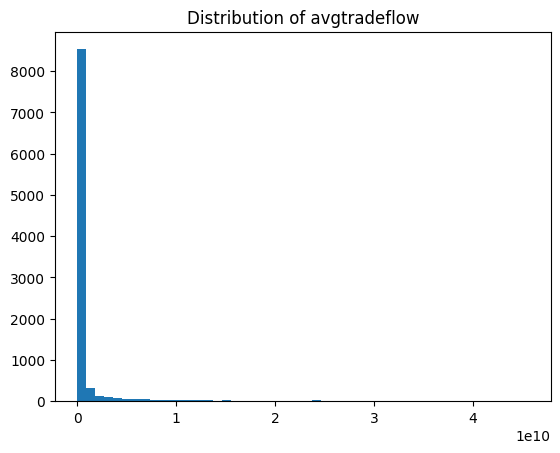

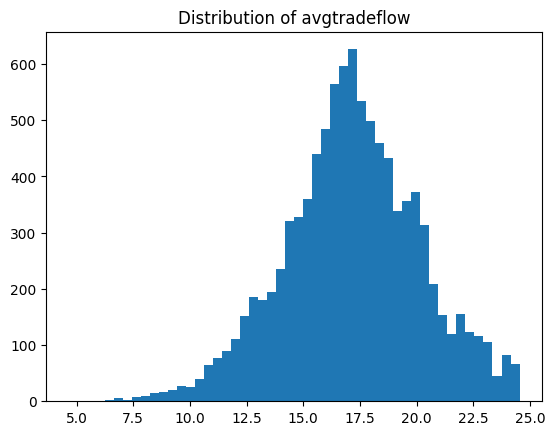

In [61]:
# Take the average since there are inconsistencies in reporting of tradeflow for each country
df['avgtradeflow'] = df[['tradeflow_comtrade_o', 'tradeflow_comtrade_d', 
                          'tradeflow_imf_o', 'tradeflow_imf_d']].mean(axis = 1, skipna = True)

plt.hist(df['avgtradeflow'].dropna(), bins=50)
plt.title('Distribution of avgtradeflow')
plt.show()

# Data is skewed so log-transform it to make distribution less skewed
df['logtradeflow'] = np.log1p(df['avgtradeflow'])
plt.hist(df['logtradeflow'].dropna(), bins=50)
plt.title('Distribution of avgtradeflow')
plt.show()

In [62]:
df = df.dropna(subset=['logtradeflow', 'IdealPointDistance'])

In [63]:
# Only a few countries with comrelig = NA and they do not have many observations
df = df.dropna(subset=['comrelig', 'gdp_d'])

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7400 entries, 56 to 14233
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  7400 non-null   int64  
 1   country_id_o          7400 non-null   object 
 2   country_o             7400 non-null   object 
 3   country_id_d          7400 non-null   object 
 4   country_d             7400 non-null   object 
 5   contig                7400 non-null   float64
 6   distcap               7400 non-null   float64
 7   dist                  7400 non-null   float64
 8   comlang_off           7400 non-null   float64
 9   comlang_ethno         7400 non-null   float64
 10  comrelig              7400 non-null   float64
 11  pop_o                 7400 non-null   float64
 12  pop_d                 7400 non-null   float64
 13  gdp_o                 7400 non-null   float64
 14  gdp_d                 7400 non-null   float64
 15  gdpcap_o              74

In [65]:
df["year"]=df["year"].astype(int)
df["contig"]=df["contig"].astype(int)
df["comlang_off"]=df["comlang_off"].astype(int)
df["comlang_ethno"]=df["comlang_ethno"].astype(int)
df["fta_wto"]=df["fta_wto"].astype(int)

In [66]:
df['contig'].value_counts()

contig
0    7400
Name: count, dtype: int64

In [67]:
# Singapore and Malaysia
df["contig"] = df.apply(lambda row: 1 if (row["country_id_o"] == "SGP" and row["country_id_d"] == "MYS.2") else 0, axis=1)

In [68]:
df_vdem_subset=df_vdem[["country_name","histname","country_text_id","year","v2x_polyarchy","v2x_libdem","v2x_partipdem","v2x_delibdem","v2x_egaldem"]]
v2x_columns = ["v2x_polyarchy", "v2x_libdem", "v2x_partipdem", "v2x_delibdem", "v2x_egaldem"]
df_vdem_o = df_vdem_subset.rename(columns={col: col + "_o" for col in v2x_columns})
df_combined = df.merge(df_vdem_o, left_on=["country_id_o", "year"], right_on=["country_text_id", "year"], how="left").drop(columns=["country_name","histname","country_text_id"])
df_vdem_d = df_vdem_subset.rename(columns={col: col + "_d" for col in v2x_columns})
df_combined = df_combined.merge(df_vdem_d, left_on=["country_id_d", "year"], right_on=["country_text_id", "year"], how="left").drop(columns=["country_name","histname","country_text_id"])
df_combined["v2x_polyarchy_d"]=df_combined["v2x_polyarchy_d"].fillna(0)
df_combined["v2x_libdem_d"]=df_combined["v2x_libdem_d"].fillna(0)
df_combined["v2x_partipdem_d"]=df_combined["v2x_partipdem_d"].fillna(0)
df_combined["v2x_delibdem_d"]=df_combined["v2x_delibdem_d"].fillna(0)
df_combined["v2x_egaldem_d"]=df_combined["v2x_egaldem_d"].fillna(0)
df_combined["v2x_polyarchy_o"]=df_combined["v2x_polyarchy_o"].fillna(0)
df_combined["v2x_libdem_o"]=df_combined["v2x_libdem_o"].fillna(0)
df_combined["v2x_partipdem_o"]=df_combined["v2x_partipdem_o"].fillna(0)
df_combined["v2x_delibdem_o"]=df_combined["v2x_delibdem_o"].fillna(0)
df_combined["v2x_egaldem_o"]=df_combined["v2x_egaldem_o"].fillna(0)

In [69]:
df_final = df_combined.merge(df_export, left_on=['country_d', 'year'], right_on=['Partner Name', 'year'], how='left').drop(columns=['Reporter Name', 'Partner Name'])

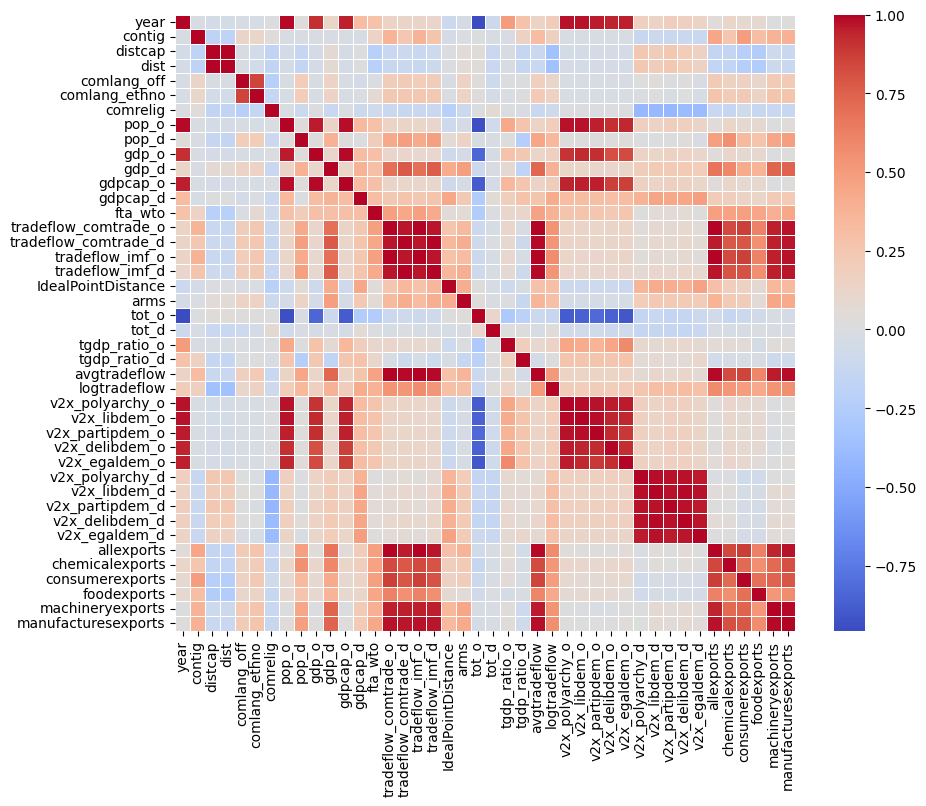

In [70]:
corr = df_final.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', linewidths=.5)
plt.show()

In [71]:
# Log transformation to make data less skewed
df_final['logallexports'] = np.log1p(df_final['allexports'])
df_final['logchemicalexports'] = np.log1p(df_final['chemicalexports'])
df_final['logconsumerexports'] = np.log1p(df_final['consumerexports'])
df_final['logfoodexports'] = np.log1p(df_final['foodexports'])
df_final['logmachineryexports'] = np.log1p(df_final['machineryexports'])
df_final['logmanufacturesexports'] = np.log1p(df_final['manufacturesexports'])

In [72]:
for _ in df_final.columns:
    print(_,sum(df_final[_].isna()))

year 0
country_id_o 0
country_o 0
country_id_d 0
country_d 0
contig 0
distcap 0
dist 0
comlang_off 0
comlang_ethno 0
comrelig 0
pop_o 0
pop_d 0
gdp_o 0
gdp_d 0
gdpcap_o 0
gdpcap_d 0
fta_wto 0
tradeflow_comtrade_o 992
tradeflow_comtrade_d 1506
tradeflow_imf_o 1587
tradeflow_imf_d 942
IdealPointDistance 0
arms 0
tot_o 1395
tot_d 2787
tgdp_ratio_o 0
tgdp_ratio_d 1216
avgtradeflow 0
logtradeflow 0
v2x_polyarchy_o 0
v2x_libdem_o 0
v2x_partipdem_o 0
v2x_delibdem_o 0
v2x_egaldem_o 0
v2x_polyarchy_d 0
v2x_libdem_d 0
v2x_partipdem_d 0
v2x_delibdem_d 0
v2x_egaldem_d 0
allexports 3128
chemicalexports 3464
consumerexports 3145
foodexports 3831
machineryexports 3268
manufacturesexports 3252
logallexports 3128
logchemicalexports 3464
logconsumerexports 3145
logfoodexports 3831
logmachineryexports 3268
logmanufacturesexports 3252


In [73]:
df_final.to_csv("../data/df_final.csv", index = False)